**Install Packages**

In [6]:
!pip install -q kaggle tensorflow opencv-python-headless matplotlib seaborn scikit-learn

**Setup Kaggle API**

In [7]:
from  google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Download and Unzip the Dataset**

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content
!unzip -q /content/chest-xray-pneumonia.zip -d /content/chest_xray_dataset
!ls -ls /content/chest_xray_dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 97% 2.23G/2.29G [00:22<00:03, 20.3MB/s]
100% 2.29G/2.29G [00:22<00:00, 111MB/s] 
total 4
4 drwxr-xr-x 7 root root 4096 Sep 17 15:00 chest_xray


In [9]:
import os
from pprint  import pprint

In [10]:
base = '/content/chest_xray_dataset/chest_xray'
splits = ['train', 'val', 'test']

In [11]:
import os
from pprint import pprint

base = '/content/chest_xray_dataset/chest_xray'
splits = ['train', 'val', 'test']

def count_classes(root):
    result = {}
    for s in splits:
        path = os.path.join(root, s)
        if not os.path.exists(path):
            continue
        classes = {}
        for cls in os.listdir(path):
            cls_path = os.path.join(path, cls)
            if os.path.isdir(cls_path):
                classes[cls] = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        result[s] = classes
    return result

pprint(count_classes(base))


{'test': {'NORMAL': 234, 'PNEUMONIA': 390},
 'train': {'NORMAL': 1341, 'PNEUMONIA': 3875},
 'val': {'NORMAL': 8, 'PNEUMONIA': 8}}


**Quick EDA**

Classes: ['NORMAL', 'PNEUMONIA']


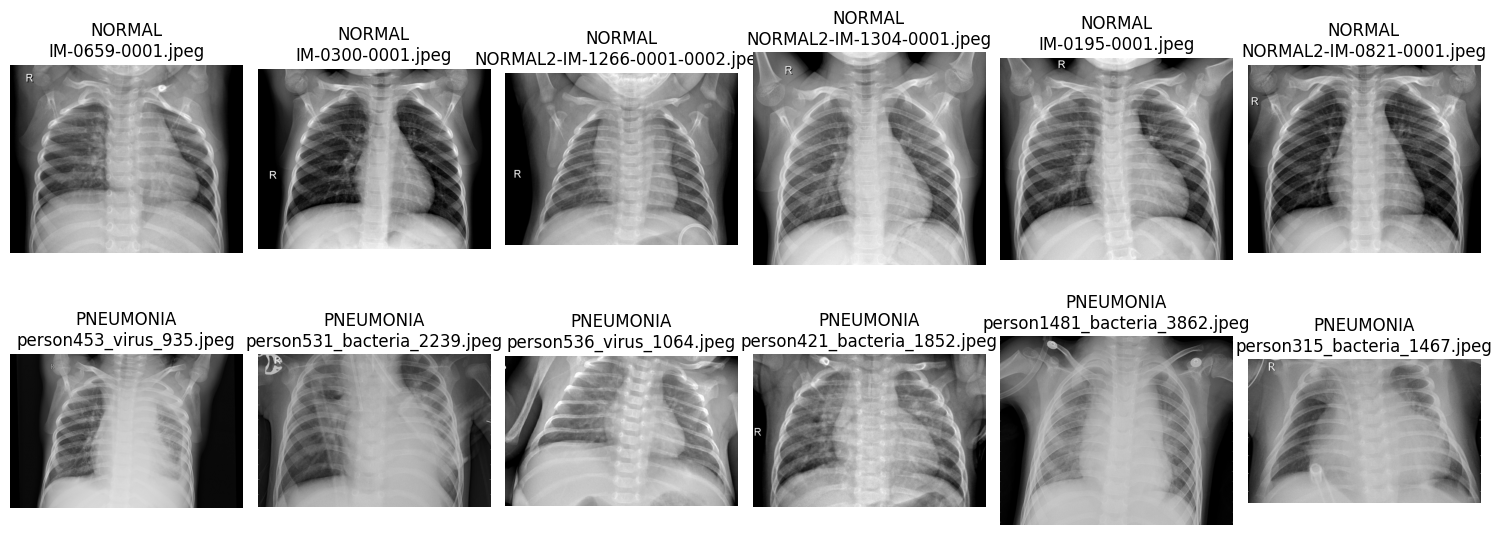

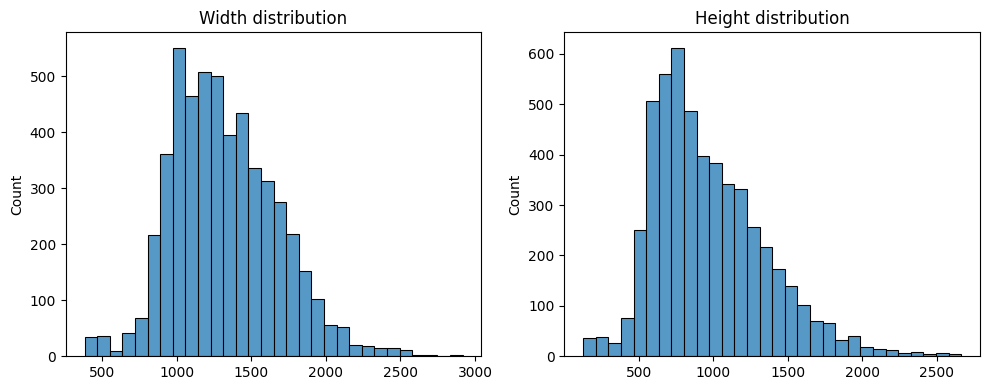

In [13]:
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_dir = '/content/chest_xray_dataset/chest_xray/train'
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print("Classes:", classes)

fig, axs = plt.subplots(len(classes), 6, figsize=(15, 3*len(classes)))
for i, cls in enumerate(classes):
    files = glob.glob(os.path.join(train_dir, cls, '*'))
    samples = random.sample(files, min(6, len(files)))
    for j, f in enumerate(samples):
        im = Image.open(f).convert('L')
        axs[i, j].imshow(im, cmap='gray')
        axs[i, j].set_title(f"{cls}\n{os.path.basename(f)}")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

# image size distribution across the train set
sizes = []
for cls in classes:
    for f in glob.glob(os.path.join(train_dir, cls, '*')):
        try:
            im = Image.open(f)
            sizes.append(im.size)  # (width, height)
        except:
            pass

sizes = np.array(sizes)
w = sizes[:,0]
h = sizes[:,1]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(w, bins=30).set(title='Width distribution')
plt.subplot(1,2,2)
sns.histplot(h, bins=30).set(title='Height distribution')
plt.tight_layout()
plt.show()

**Check for corrupted images**

In [14]:
import imghdr

corrupt = []
for split in splits:
    for root, dirs, files in os.walk(os.path.join(base, split)):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                typ = imghdr.what(path)
                if typ is None:
                    corrupt.append(path)
            except:
                corrupt.append(path)

print("Found", len(corrupt), "corrupted images (should be 0).")
corrupt[:10]


Found 0 corrupted images (should be 0).


/tmp/ipython-input-4025714231.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


[]

**Prepare tf.data pipeline (image_dataset_from_directory) with augmentation**

In [17]:
import tensorflow as ts

IMG_SIZE = (224,224)
BATCH = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base, 'train'),
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base, 'test'),
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base, 'val'),
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)


class_names = train_ds.class_names
print("Class names:", class_names)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Class names: ['NORMAL', 'PNEUMONIA']


**Prefetch, normalizing, and augmentation layer**

In [18]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.06),
    layers.RandomContrast(0.05),
], name='data_augmentation')

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(lambda x,y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x,y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


**Compute class weights**

In [20]:
import numpy as np
from sklearn.utils import class_weight


y_train = np.concatenate([y.numpy() for x,y in train_ds.unbatch().batch(1000000)])
y_train = y_train.astype(int).ravel()

classes = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {int(classes[i]): float(cw[i]) for i in range(len(classes))}
print("Class weights:", class_weights)


Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


**Ready for model training**

In [21]:
from tensorflow.keras import layers, models, applications, optimizers, losses, metrics

IMG_SHAPE = IMG_SIZE + (3,)

base_model = applications.DenseNet121(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False   # freeze base for initial training

inputs = layers.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.BinaryCrossentropy(),
    metrics=['accuracy', metrics.AUC(name='auc')]
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Callbacks and training**

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint_path = '/content/best_densenet_pneumonia.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_auc', patience=6, mode='max', restore_best_weights=True, verbose=1)
]

EPOCHS = 12

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4253 - auc: 0.5435 - loss: 0.7982
Epoch 1: val_auc improved from -inf to 0.64844, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 661ms/step - accuracy: 0.4259 - auc: 0.5438 - loss: 0.7978 - val_accuracy: 0.5625 - val_auc: 0.6484 - val_loss: 0.6862 - learning_rate: 1.0000e-04
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.6178 - auc: 0.6763 - loss: 0.6552
Epoch 2: val_auc improved from 0.64844 to 0.87500, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 518ms/step - accuracy: 0.6179 - auc: 0.6765 - loss: 0.6550 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 0.6026 - learning_rate: 1.0000e-04
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7084 - auc: 0.7799 - loss: 0.5770
Epoch 3: val_auc improved from 0.87500 to 0.90625, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 515ms/step - accuracy: 0.7085 - auc: 0.7800 - loss: 0.5768 - val_accuracy: 0.6875 - val_auc: 0.9062 - val_loss: 0.5485 - learning_rate: 1.0000e-04
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.7863 - auc: 0.8632 - loss: 0.4932
Epoch 4: val_auc did not improve from 0.90625
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 516ms/step - accuracy: 0.7863 - auc: 0.8633 - loss: 0.4931 - val_accuracy: 0.6875 - val_auc: 0.9062 - val_loss: 0.5126 - learning_rate: 1.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8064 - auc: 0.8887 - loss: 0.4519
Epoch 5: val_auc improved from 0.90625 to 0.92188, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 518ms/step - accuracy: 0.8064 - auc: 0.8887 - loss: 0.4518 - val_accuracy: 0.6875 - val_auc: 0.9219 - val_loss: 0.5123 - learning_rate: 1.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8287 - auc: 0.9086 - loss: 0.4168
Epoch 6: val_auc improved from 0.92188 to 0.92969, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 511ms/step - accuracy: 0.8287 - auc: 0.9087 - loss: 0.4168 - val_accuracy: 0.7500 - val_auc: 0.9297 - val_loss: 0.4682 - learning_rate: 1.0000e-04
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8512 - auc: 0.9222 - loss: 0.3915
Epoch 7: val_auc did not improve from 0.92969
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 515ms/step - accuracy: 0.8511 - auc: 0.9222 - loss: 0.3914 - val_accuracy: 0.7500 - val_auc: 0.9297 - val_loss: 0.4687 - learning_rate: 1.0000e-04
Epoch 8/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8656 - auc: 0.9435 - loss: 0.3476
Epoch 8: val_auc improved from 0.92969 to 0.93750, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 516ms/step - accuracy: 0.8656 - auc: 0.9435 - loss: 0.3476 - val_accuracy: 0.7500 - val_auc: 0.9375 - val_loss: 0.4472 - learning_rate: 1.0000e-04
Epoch 9/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8611 - auc: 0.9350 - loss: 0.3549
Epoch 9: val_auc did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 505ms/step - accuracy: 0.8611 - auc: 0.9350 - loss: 0.3548 - val_accuracy: 0.7500 - val_auc: 0.9375 - val_loss: 0.4456 - learning_rate: 1.0000e-04
Epoch 10/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8786 - auc: 0.9439 - loss: 0.3311
Epoch 10: val_auc improved from 0.93750 to 0.96875, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 515ms/step - accuracy: 0.8786 - auc: 0.9439 - loss: 0.3311 - val_accuracy: 0.7500 - val_auc: 0.9688 - val_loss: 0.4264 - learning_rate: 1.0000e-04
Epoch 11/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8794 - auc: 0.9520 - loss: 0.3117
Epoch 11: val_auc did not improve from 0.96875
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 516ms/step - accuracy: 0.8794 - auc: 0.9520 - loss: 0.3117 - val_accuracy: 0.7500 - val_auc: 0.9688 - val_loss: 0.4216 - learning_rate: 1.0000e-04
Epoch 12/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8806 - auc: 0.9560 - loss: 0.3029
Epoch 12: val_auc did not improve from 0.96875
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 514ms/step - accuracy: 0.8806 - auc: 0.9560 - loss: 0.3029 - val_accuracy: 0.7500 - val_auc: 0.9688 - val_loss: 0.4191 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


**Fine Tune**

In [23]:
base_model.trainable = True

for layer in base_model.layers[:300]:
    layer.trainable = False
for layer in base_model.layers[300:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=losses.BinaryCrossentropy(),
    metrics=['accuracy', metrics.AUC(name='auc')]
)

history_ft = model.fit(
    train_ds,
    epochs=8,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8696 - auc: 0.9416 - loss: 0.4532
Epoch 1: val_auc improved from 0.96875 to 0.98438, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 584ms/step - accuracy: 0.8698 - auc: 0.9417 - loss: 0.4523 - val_accuracy: 0.6875 - val_auc: 0.9844 - val_loss: 0.4187 - learning_rate: 1.0000e-05
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9317 - auc: 0.9803 - loss: 0.1789
Epoch 2: val_auc improved from 0.98438 to 1.00000, saving model to /content/best_densenet_pneumonia.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 528ms/step - accuracy: 0.9317 - auc: 0.9803 - loss: 0.1789 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2307 - learning_rate: 1.0000e-05
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9396 - auc: 0.9849 - loss: 0.1543
Epoch 3: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 524ms/step - accuracy: 0.9396 - auc: 0.9849 - loss: 0.1543 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1297 - learning_rate: 1.0000e-05
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9513 - auc: 0.9896 - loss: 0.1307
Epoch 4: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 525ms/step - accuracy: 0.9513 - auc: 0.9896 - loss: 0.1307 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1043 - learning_rate: 1.0000e-05
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9568 - auc: 0.9924 - loss: 0.1103
Epoch 5: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━

**Plot training curves & evaluate on test set**

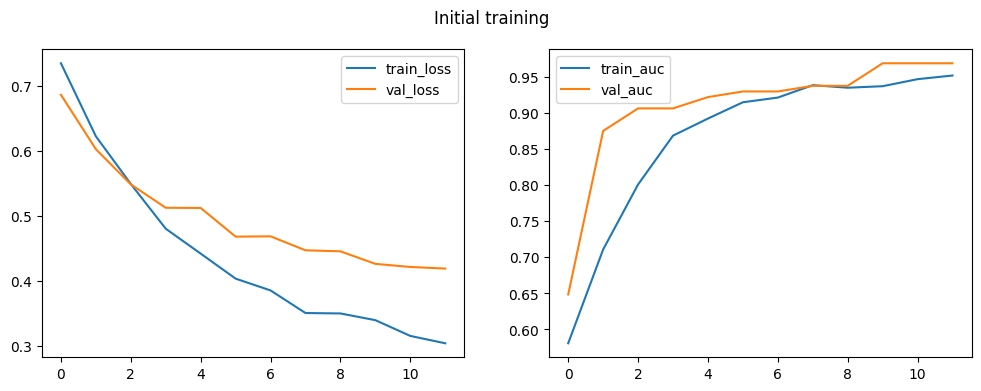

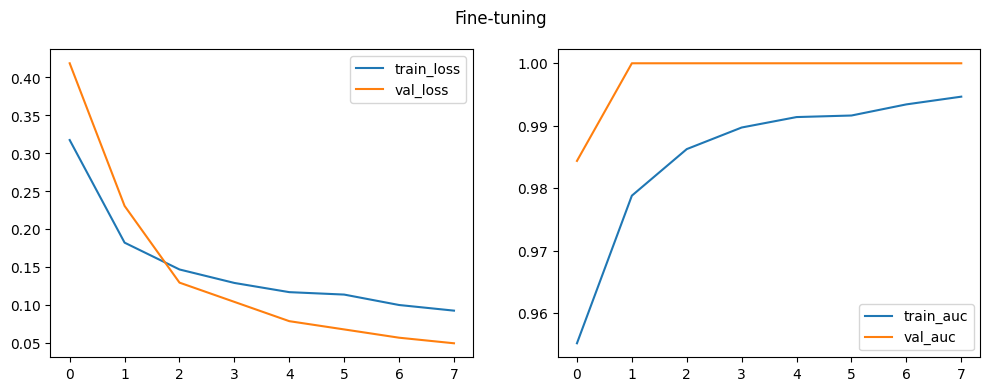

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Classification report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.84      0.87       234
   PNEUMONIA       0.91      0.94      0.92       390

    accuracy                       

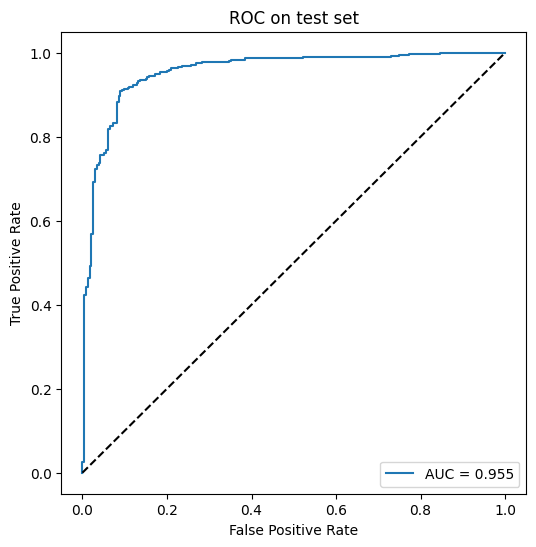

In [25]:
# Colab cell 14 — plot metrics, evaluate on test
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

def plot_history(h, title='history'):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['auc'], label='train_auc')
    plt.plot(h.history['val_auc'], label='val_auc')
    plt.legend()
    plt.suptitle(title)
    plt.show()

plot_history(history, 'Initial training')
if 'history_ft' in globals():
    plot_history(history_ft, 'Fine-tuning')

# Evaluate on test set and compute metrics
# get predictions (probabilities)
y_true = []
y_pred_prob = []

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch)
    y_true.extend(y_batch.numpy().tolist())
    y_pred_prob.extend(probs.ravel().tolist())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC on test set')
plt.show()


**Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


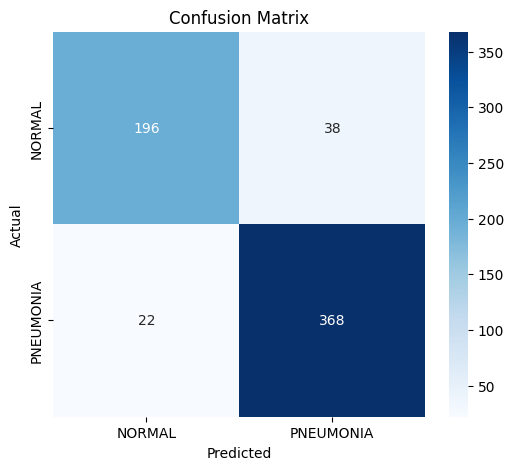

              precision    recall  f1-score   support

      NORMAL       0.90      0.84      0.87       234
   PNEUMONIA       0.91      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.90       624
weighted avg       0.90      0.90      0.90       624



In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Collect ground-truth labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend((probs.ravel() > 0.5).astype(int))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


**Save your model & artifacts**

In [40]:
model.save("/content/final_densenet_pneumonia.keras")
model.save("/content/final_densenet_pneumonia.h5")
model.export("/content/final_densenet_pneumonia_saved_model")



Saved artifact at '/content/final_densenet_pneumonia_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_432')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136046179103376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179103568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179104528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179104144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179104336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179106256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179106448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179105680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179105104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136046179105296: TensorSpec(shape=(), dtype=tf.reso